https://towardsdatascience.com/lossless-triplet-loss-7e932f990b24 참조

In [17]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, BatchNormalization, LSTM, Dense, concatenate, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam, SGD
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import cv2

In [4]:
data_dir = './DB12/'

In [5]:
batch_size = 1176

train_datagen = ImageDataGenerator(rescale=1./255 )
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                        data_dir,  # this is the target directory
                        target_size=(150, 150),  # 모든 이미지의 크기가 150x150로 조정됩니다.
                        batch_size=batch_size,)

batch = train_generator.next()
images = batch[0]
labels = batch[1]

# images = images.reshape(-1, 150, 150)
labels = np.array([np.argmax(x) for x in labels])

Found 1176 images belonging to 98 classes.


In [6]:
images.shape

(1176, 150, 150, 3)

In [8]:
labels.shape

(1176,)

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.33, random_state=42)

In [11]:
X_train.shape

(787, 150, 150, 3)

In [12]:
y_train.shape

(787,)

In [42]:
sample_size = 3000

a, p, n = get_triplets(images, sample_size)
y_dummie = np.ones(sample_size)

In [43]:
a.shape

(3000, 150, 150, 3)

In [14]:
def cnn_base_network(in_dims, out_dims):
    model = Sequential()

    #CNN의 차이점은 바로 input layer!!!
    model.add(Conv2D(input_shape = in_dims,
                     filters = 10, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation='relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())    #1차원화

    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(out_dims, activation = 'relu'))

    return model

In [44]:
in_dims = (a.shape[1], a.shape[2], a.shape[3])
out_dims = 64

# Create the 3 inputs
anchor_in = Input(shape=in_dims)
pos_in = Input(shape=in_dims)
neg_in = Input(shape=in_dims)

# with tf.compat.v1.Session(config=config):
    # Share base network with the 3 inputs
base_network = cnn_base_network(in_dims, out_dims)
anchor_out = base_network(anchor_in)
pos_out = base_network(pos_in)
neg_out = base_network(neg_in)
    
merged_vector = concatenate([anchor_out, pos_out, neg_out], axis=-1)
# Define the trainable model
model = Model(inputs=[anchor_in, pos_in, neg_in], outputs=merged_vector)
model.compile(optimizer=Adam(learning_rate=0.0001),
                    loss=triplet_loss)

In [45]:
# Training the model
H = model.fit([a, p, n], y_dummie, batch_size=20, epochs=20)

Epoch 1/20
3000/3000 [==============================] - 84s 28ms/step - loss: 0.3310
Epoch 2/20
3000/3000 [==============================] - 78s 26ms/step - loss: 0.2136
Epoch 3/20
3000/3000 [==============================] - 78s 26ms/step - loss: 0.2014
Epoch 4/20
3000/3000 [==============================] - 78s 26ms/step - loss: 0.2038
Epoch 5/20
3000/3000 [==============================] - 77s 26ms/step - loss: 0.1980
Epoch 6/20
3000/3000 [==============================] - 80s 27ms/step - loss: 0.2059
Epoch 7/20
3000/3000 [==============================] - 80s 27ms/step - loss: 0.2024
Epoch 8/20
3000/3000 [==============================] - 76s 25ms/step - loss: 0.1883
Epoch 9/20
3000/3000 [==============================] - 77s 26ms/step - loss: 0.2059
Epoch 10/20
3000/3000 [==============================] - 77s 26ms/step - loss: 0.2034
Epoch 11/20
3000/3000 [==============================] - 77s 26ms/step - loss: 0.2061
Epoch 12/20
3000/3000 [==============================] - 77s 26

# 0. GPU resource allocation

In [34]:
config = tf.compat.v1.ConfigProto()

config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.visible_device_list = "0"
session = tf.compat.v1.Session(config=config)

# 1. Define loss & base network
- 두 가지 loss 함수
    - `triplet_loss`
        - loss값이 20-40대에서 줄어들지 않음
        - 출처: https://thelonenutblog.wordpress.com/2017/12/18/what-siamese-dreams-are-made-of/
    - `lossless_triplet_loss`
        - 첫 epoch부터 loss가 nan으로 나옴
        - 출처: https://towardsdatascience.com/lossless-triplet-loss-7e932f990b24

In [15]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, not used in this function.
    y_pred -- python list containing three objects:
            anchor:   the encodings for the anchor data
            positive: the encodings for the positive data (similar to anchor)
            negative: the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """

    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    # distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)))

    # distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)))

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha

    loss = tf.maximum(basic_loss,0.0)

    return loss

In [26]:
def lossless_triplet_loss(y_true, y_pred, N=3, beta=3, epsilon=1e-8):
    """
    Implementation of the triplet loss function
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    N  --  The number of dimension 
    beta -- The scaling factor, N is recommended
    epsilon -- The Epsilon value to prevent ln(0)
    
    
    Returns:
    loss -- real number, value of the loss
    """
    anchor = tf.convert_to_tensor(y_pred[:,0:N])
    positive = tf.convert_to_tensor(y_pred[:,N:N*2]) 
    negative = tf.convert_to_tensor(y_pred[:,N*2:N*3])
    
    # distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),1)
    # distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),1)
    
    #Non Linear Values  
    
    # -ln(-x/N+1)
    pos_dist = -tf.math.log(-tf.divide((pos_dist),beta)+1+epsilon)
    neg_dist = -tf.math.log(-tf.divide((N-neg_dist),beta)+1+epsilon)
    
    # compute loss
    loss = neg_dist + pos_dist
    
    return loss

In [10]:
def create_base_network(in_dims, out_dims):
    """
    Base network to be shared.
    """
    model = Sequential()
    model.add(BatchNormalization(input_shape=in_dims))
    model.add(LSTM(512, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, implementation=2))
    model.add(LSTM(512, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, implementation=2))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(254, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(254, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(out_dims, activation='sigmoid'))
    model.add(BatchNormalization())

    return model

# 2. Load data

In [113]:
model_dir = 'experiments/insta'
data_dir = '../pre_DB12'

In [114]:
batch_size = 1176

train_datagen = ImageDataGenerator(rescale=1./255 )
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                        data_dir,  # this is the target directory
                        target_size=(150, 150),  # 모든 이미지의 크기가 150x150로 조정됩니다.
                        batch_size=batch_size,
                        color_mode='grayscale')

batch = train_generator.next()
images = batch[0]
labels = batch[1]

images = images.reshape(-1, 150, 150)
labels = np.array([np.argmax(x) for x in labels])

Found 909 images belonging to 94 classes.


In [115]:
images.shape

(909, 150, 150)

In [116]:
images[0].shape

(150, 150)

In [117]:
labels.shape

(909,)

## 2.1 triplet sampling

In [41]:
def get_triplets(images, sample_size):
    anchors = []
    positives = []
    negatives = []
    
    while len(anchors) < sample_size:
        num1, num2 = random.sample(range(93), 2)
        positive_pool = images[np.where(labels == num1)[0]]
        negative_pool = images[np.where(labels == num2)[0]]
        num3, num4 = random.sample(range(len(positive_pool)), 2)
                            
        anchor = positive_pool[num3]
        positive = positive_pool[num4]
        negative = images[np.where(labels == num2)][random.randint(0, len(negative_pool)-1)]

        anchors.append(anchor)
        positives.append(positive)
        negatives.append(negative)
    
    anchors = np.array(anchors)
    positives = np.array(positives)
    negatives = np.array(negatives)
    
    return anchors, positives, negatives

In [17]:
# test get_triplets
a, p, n = get_triplets(images, 10)

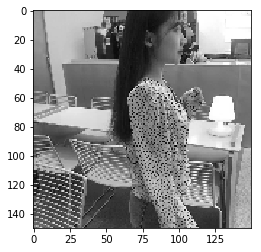

In [120]:
plt.imshow(a[0], cmap = 'gray')   #0th anchor

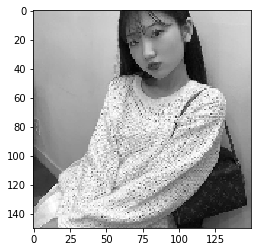

In [121]:
plt.imshow(p[0], cmap = 'gray')   #0th positive point

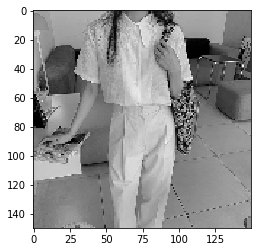

In [122]:
plt.imshow(n[0], cmap = 'gray')    #0th negative point

In [21]:
del a, p, n

In [119]:
sample_size = 3000

a, p, n = get_triplets(images, sample_size)
y_dummie = np.ones(sample_size)

# 3. Create model

In [29]:
in_dims = (150, 150)
out_dims = 64


# Create the 3 inputs
anchor_in = Input(shape=in_dims)
pos_in = Input(shape=in_dims)
neg_in = Input(shape=in_dims)


# with tf.compat.v1.Session(config=config):
    # Share base network with the 3 inputs
base_network = create_base_network(in_dims, out_dims)
anchor_out = base_network(anchor_in)
pos_out = base_network(pos_in)
neg_out = base_network(neg_in)
    
merged_vector = concatenate([anchor_out, pos_out, neg_out], axis=-1)
# Define the trainable model
model = Model(inputs=[anchor_in, pos_in, neg_in], outputs=merged_vector)
model.compile(optimizer=Adam(learning_rate=0.0001),
                    loss=triplet_loss)

In [30]:
base_network.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_25 (Batc (None, 150, 150)          600       
_________________________________________________________________
lstm_7 (LSTM)                (None, 150, 512)          1357824   
_________________________________________________________________
lstm_8 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
batch_normalization_26 (Batc (None, 512)               2048      
_________________________________________________________________
dense_19 (Dense)             (None, 512)               262656    
_________________________________________________________________
batch_normalization_27 (Batc (None, 512)               2048      
_________________________________________________________________
dense_20 (Dense)             (None, 254)              

In [31]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 150, 150)     0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 150, 150)     0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 150, 150)     0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 64)           3967560     input_16[0][0]                   
                                                                 input_17[0][0]             

# 4. Train

In [36]:
# Training the model
H = model.fit([a, p, n], y_dummie, batch_size=20, epochs=20)

Epoch 1/20
3000/3000 [==============================] - 97s 32ms/step - loss: 27.6017
Epoch 2/20
3000/3000 [==============================] - 97s 32ms/step - loss: 25.9174
Epoch 3/20
3000/3000 [==============================] - 97s 32ms/step - loss: 29.6035
Epoch 4/20
3000/3000 [==============================] - 97s 32ms/step - loss: 29.6684
Epoch 5/20
3000/3000 [==============================] - 97s 32ms/step - loss: 26.7978
Epoch 6/20
3000/3000 [==============================] - 97s 32ms/step - loss: 29.5860
Epoch 7/20
3000/3000 [==============================] - 97s 32ms/step - loss: 28.7015
Epoch 8/20
3000/3000 [==============================] - 97s 32ms/step - loss: 22.1870
Epoch 9/20
3000/3000 [==============================] - 97s 32ms/step - loss: 34.2097
Epoch 10/20
3000/3000 [==============================] - 97s 32ms/step - loss: 29.6183
Epoch 11/20
3000/3000 [==============================] - 96s 32ms/step - loss: 29.9013
Epoch 12/20
3000/3000 [=============================

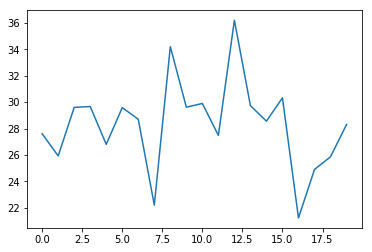

In [171]:
#결과 확인
plt.plot(H.history['loss'])
# plt.legend(['loss'], loc = 'upper left')
plt.show()

# 5. Evaluate

# 6. Predict

# 7. Application

In [41]:
def item_to_encoding(item, model):
    return model.predict(np.array([item]))

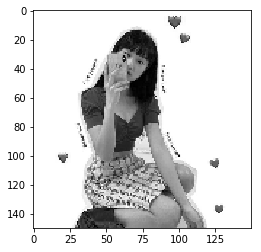

In [138]:
plt.imshow(images[0], cmap = 'gray')

In [139]:
item_to_encoding(images[0], base_network)

array([[-1.1848074 , -0.80932605, -0.9878942 , -1.785569  , -0.39547205,
         1.0444603 ,  1.5485871 ,  1.2919631 , -0.6747905 ,  1.0078156 ,
        -1.5440986 ,  0.10162711, -0.07792997,  0.9510871 , -1.1300387 ,
         0.12376261, -0.37412667,  0.523551  ,  1.4917066 ,  0.58489823,
         1.5523937 , -0.01119685,  1.2372298 , -1.5097485 , -1.261322  ,
         0.04204583, -0.32865715, -0.990929  ,  1.0067472 ,  0.27248216,
        -1.541196  , -0.44109952, -0.39824414,  0.32096672,  0.8795632 ,
        -1.0400289 , -0.5842185 , -0.6459286 ,  0.01437712, -0.19005978,
        -0.07726431, -0.79389524,  0.6410186 ,  0.48146057, -0.44583726,
        -1.2742963 ,  0.8222449 ,  0.10445213,  0.23192692, -0.1009872 ,
        -0.8973092 , -0.5814445 , -1.0216876 , -0.45872092,  0.77455187,
         0.13948059, -0.16692638,  1.6104219 , -0.47513747,  0.2865957 ,
         0.6126597 , -0.97234917, -0.07889771, -0.6070498 ]],
      dtype=float32)

In [140]:
labels[0]

8

In [131]:
labels_eng = os.listdir("../pre_DB12/")
labels_eng.sort()
labels_eng.remove('.DS_Store')

In [132]:
labels_dict = dict(enumerate(labels_eng))

In [133]:
labels_dict

{0: '0.94k',
 1: '4x2a',
 2: '__kfashions',
 3: '_daisyys',
 4: '_moaol',
 5: '_noncode_',
 6: '_sosovely_',
 7: '_unjin_',
 8: 'acubi_club',
 9: 'aestheticssoul_',
 10: 'aiko_casual',
 11: 'and_more_seoul',
 12: 'andsimpleofficial',
 13: 'angelic_co_',
 14: 'arif.house',
 15: 'asyoulikeit_shop',
 16: 'beigee_au',
 17: 'bigking0720',
 18: 'bitda_com',
 19: 'blackup_kr',
 20: 'bleu_roze_',
 21: 'butterheim',
 22: 'by_lamour',
 23: 'chaedo_nayoung',
 24: 'choa_joah',
 25: 'closeclip',
 26: 'closetme_official',
 27: 'commonunique_official',
 28: 'cosmiccgirlss',
 29: 'darkvictory_official',
 30: 'ddalgiwoouuuuuuuuu',
 31: 'dressesloves',
 32: 'eden.seoul',
 33: 'etmon_official',
 34: 'femmemuse_official',
 35: 'float.un',
 36: 'frombeginning_',
 37: 'fromgirls55',
 38: 'heartberry_studio',
 39: 'hee.xox',
 40: 'honeysoymelon',
 41: 'huagaleria',
 42: 'ini_iii',
 43: 'j_blin',
 44: 'januaryrose_insta',
 45: 'jessavintage',
 46: 'k.fash10n',
 47: 'k.korean.fashion',
 48: 'k.orean.style',
 4

In [141]:
labels_dict[labels[0]]

'acubi_club'

In [ ]:
def load_images_from_folder(folder):
    items = {}
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

## 7.1 Load items to tag

In [278]:
data_dir = '../seoulstore'
batch_size = 381

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
                        data_dir,  # this is the target directory
                        target_size=(150, 150),  # 모든 이미지의 크기가 150x150로 조정됩니다.
                        batch_size=batch_size,
                        color_mode = 'grayscale')

batch = test_generator.next()
items = batch[0]

items = items.reshape(-1, 150, 150)

Found 381 images belonging to 2 classes.


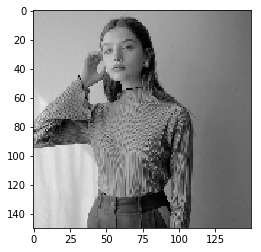

In [279]:
plt.imshow(items[0], cmap = 'gray')

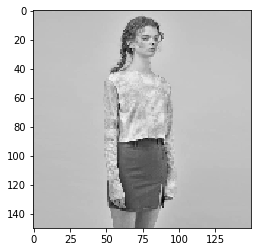

7.6200356


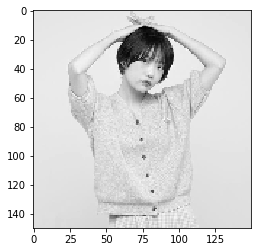

6.3954325


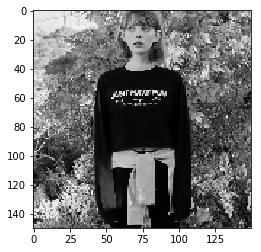

8.581071


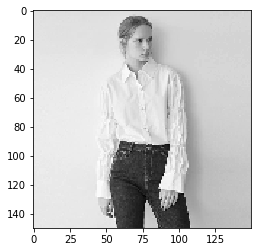

7.956894


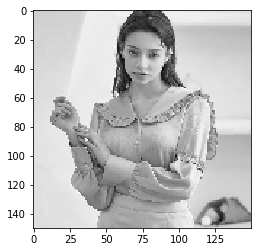

7.806994


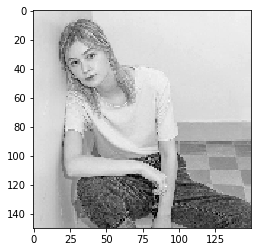

8.792898


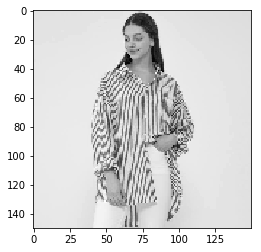

6.886918


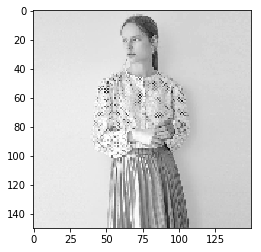

6.917982


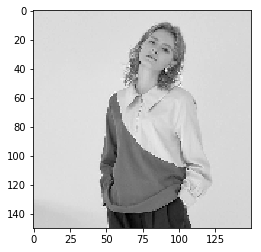

9.890228


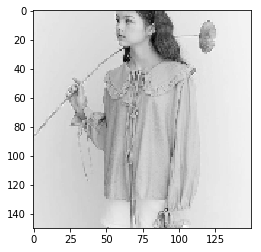

7.141714


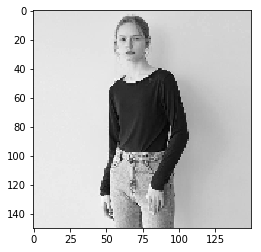

6.720514


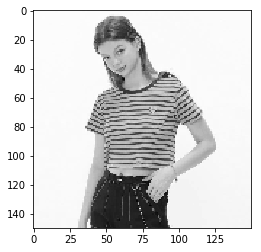

7.1158843


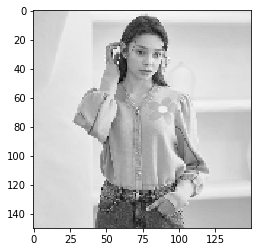

7.3473496


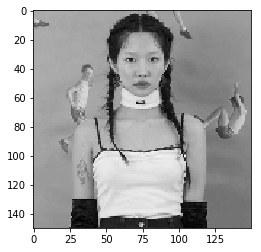

10.643147


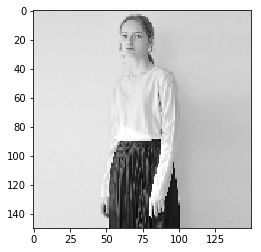

8.058085


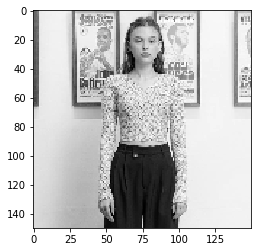

7.6805816


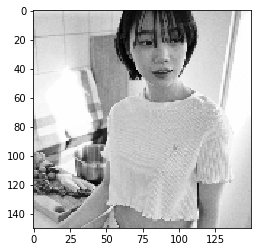

11.054736


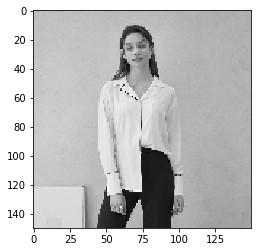

9.97835


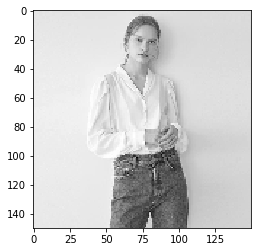

7.4388595


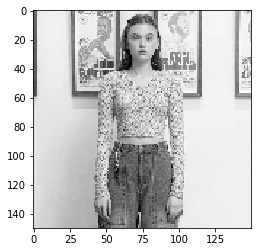

7.952934


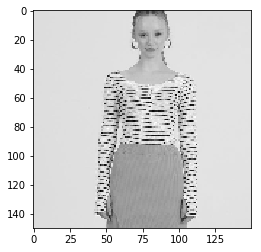

6.354675


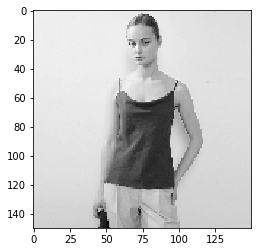

6.025244


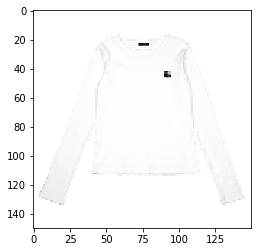

7.067633


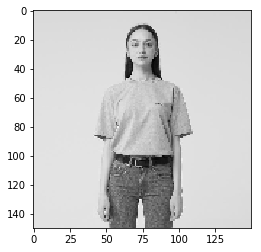

6.3292766


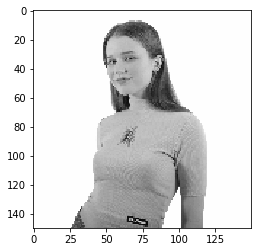

4.440401


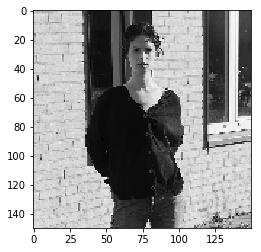

9.186694


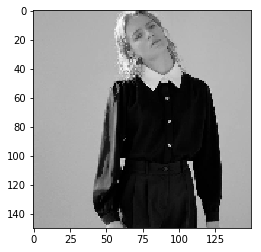

11.871242


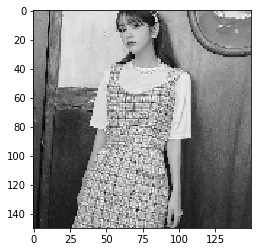

9.762779


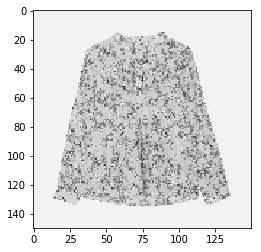

6.8732505


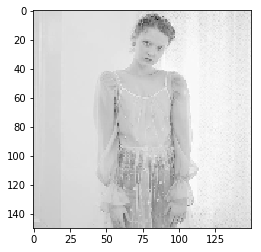

7.442963


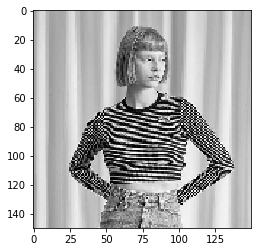

6.5813823


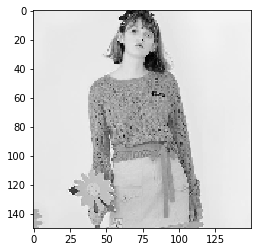

5.651693


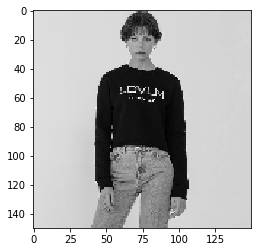

6.1093097


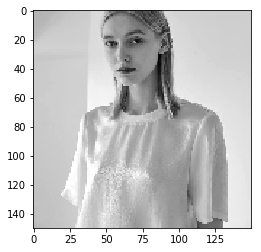

5.6303835


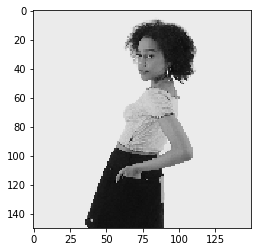

7.793366


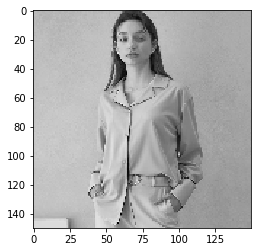

10.895332


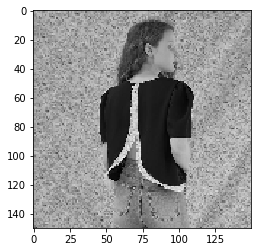

11.010123


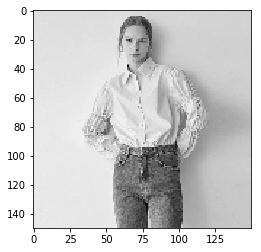

7.714766


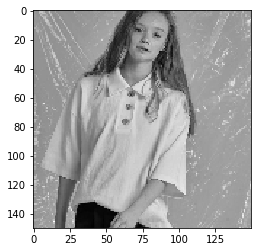

11.524339


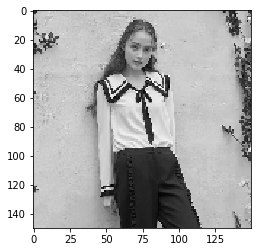

10.194908


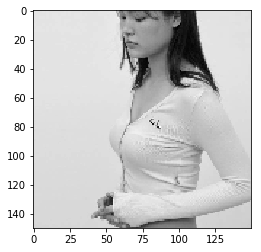

8.851277


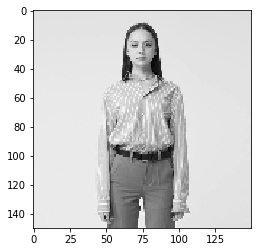

6.225955


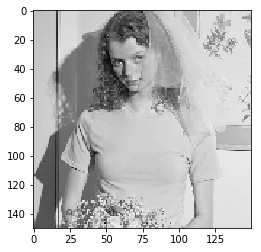

11.742597


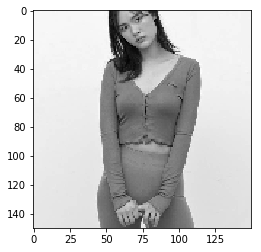

10.06133


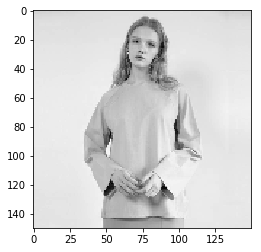

6.6259637


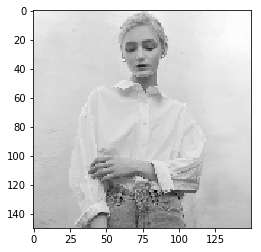

6.964163


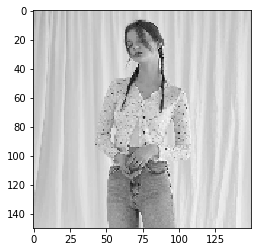

8.401887


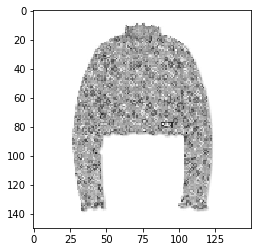

6.7702737


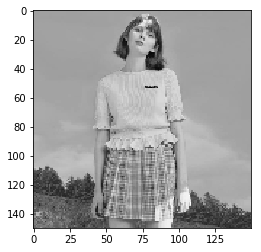

10.581226


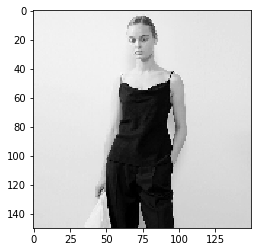

7.6952353


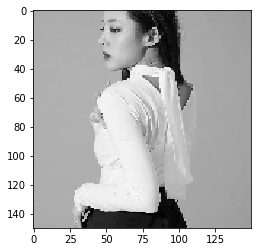

10.504705


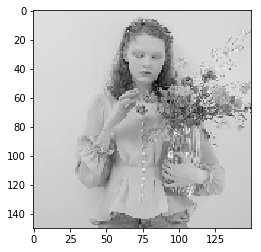

5.8062463


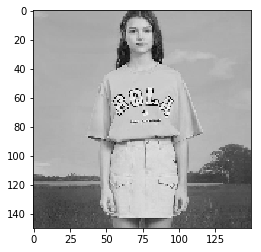

10.979173


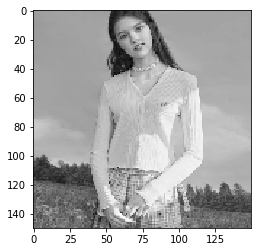

10.859135


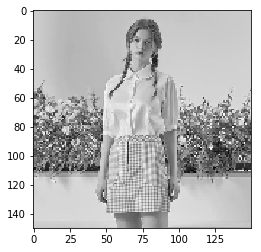

7.5188894


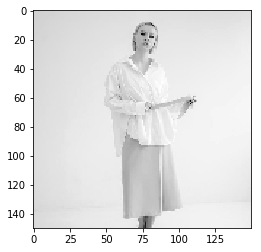

7.8090982


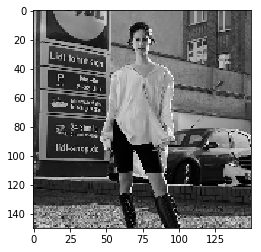

10.098145


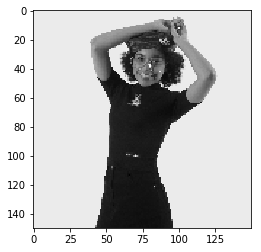

6.619513


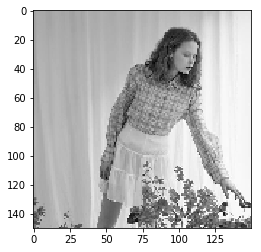

8.217344


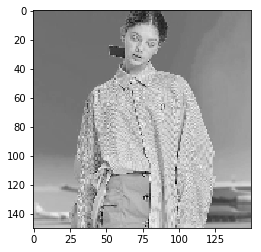

11.642494


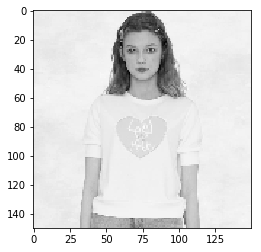

7.0477104


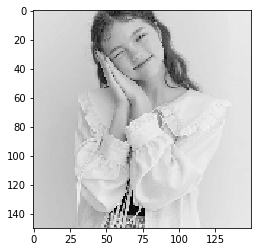

7.3533053


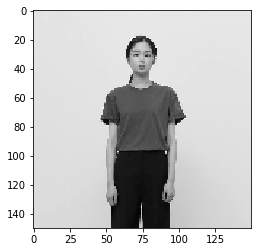

7.7728486


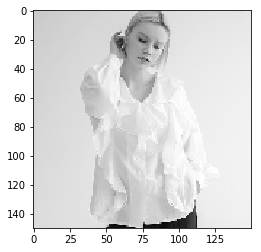

5.4459147


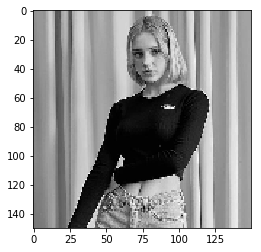

8.806832


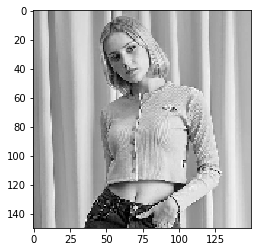

9.728232


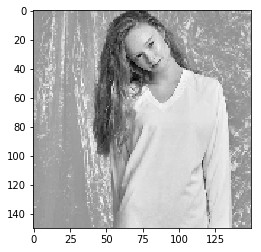

9.989834


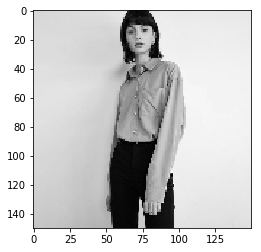

6.5850573


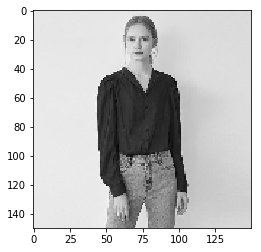

6.894541


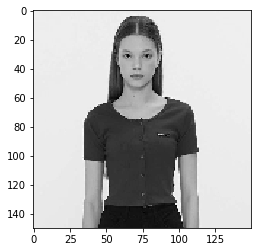

10.785635


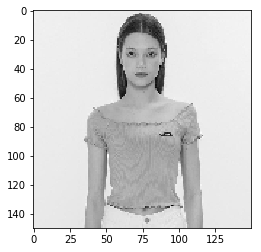

6.2468176


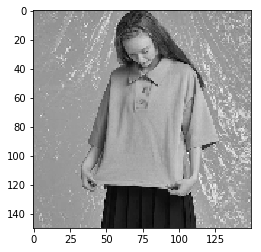

11.855193


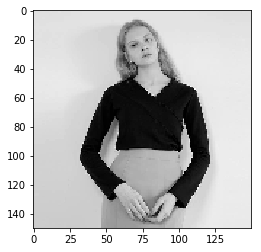

8.911901


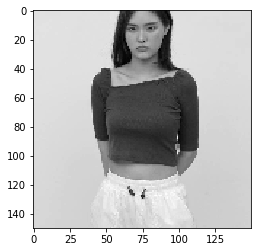

8.143759


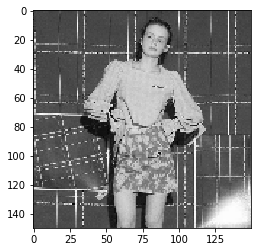

10.877363


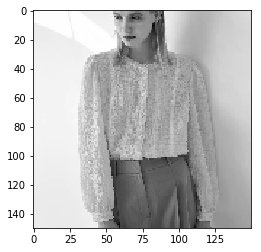

7.68133


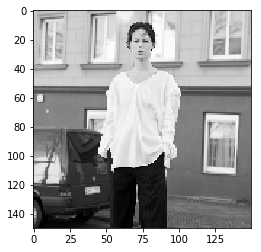

12.36838


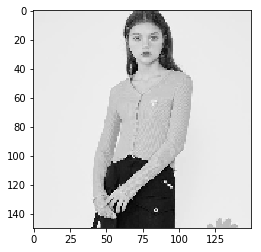

6.4669814


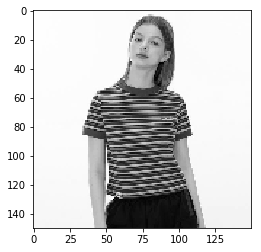

10.652276


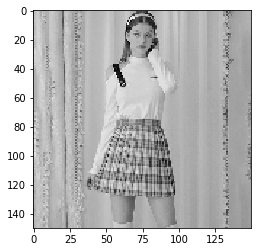

10.685429


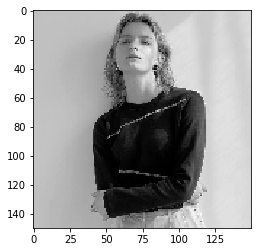

9.726046


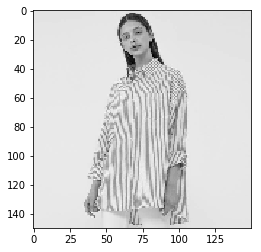

6.806159


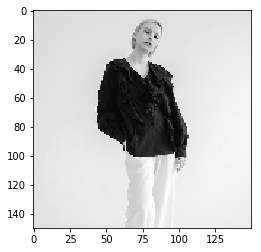

7.2969093


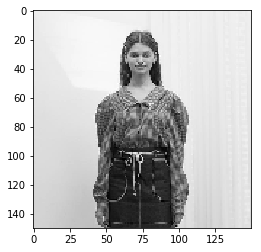

8.409119


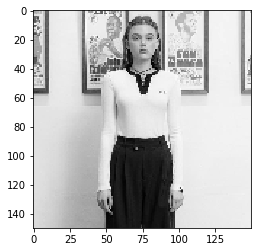

7.7422857


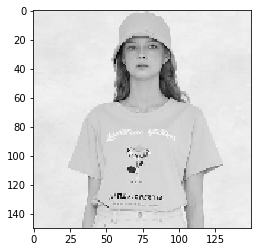

6.3988056


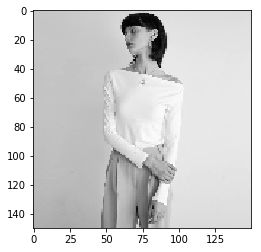

7.9037423


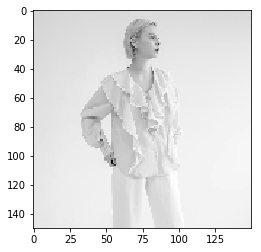

7.329815


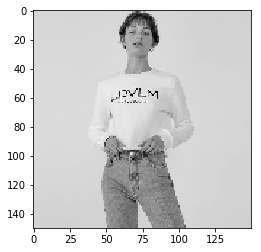

6.3699427


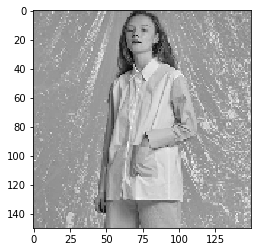

8.325762


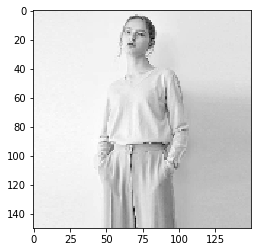

5.941387


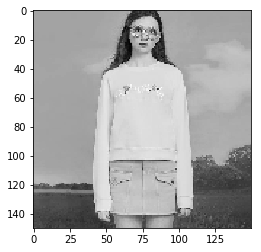

11.182823


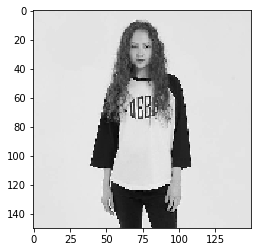

6.9040136


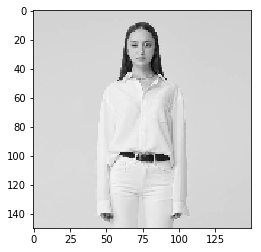

6.0604334


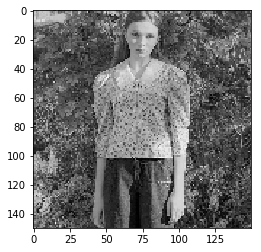

10.825319


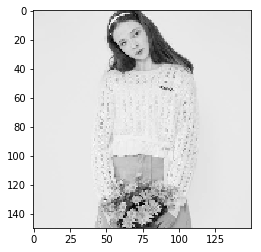

7.4301786


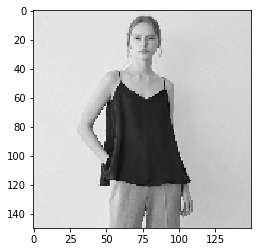

7.41655


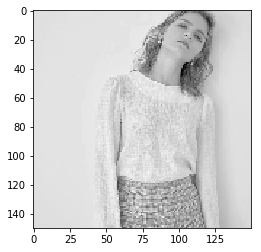

6.98328


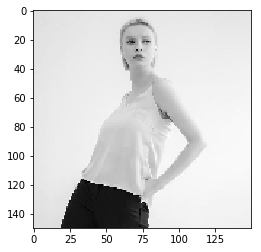

9.101643


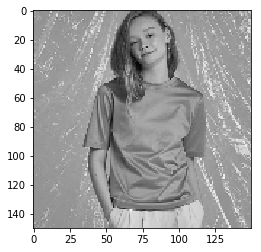

9.853838


In [185]:
for item in items[:100]:
    plt.imshow(item, cmap = 'gray')
    plt.show()
    item_encoding = item_to_encoding(item, base_network)
    dist = np.linalg.norm(image_encoding-item_encoding)
    print(dist)

In [202]:
thresh = 7

plt.figure(figsize=(150, 150))

cc = 3
rr = int(len(items[:10]) / cc)+1

plt.subplot( rr ,cc, 1)
plt.imshow(images[0], cmap = 'gray')
plt.xlabel("Anchor", fontsize=80)


for k in range(len(items[:10])):        
    i = items[k]          
    plt.subplot( rr ,cc, k+2)   # 몇 칼럼 몇 로우로 그래프 그릴지
    plt.imshow(i, cmap = 'gray')
    item_encoding = item_to_encoding(i, base_network)
    dist = np.linalg.norm(image_encoding-item_encoding)
    c =  "blue" if  dist < thresh  else "red"
    plt.xlabel("distance from anchor: {:.2f}".format(dist),  color = c, fontsize=80)

In [272]:
def identify_item(item, database, model, thresh_dist=7):
    """
    Implements item recognition.
    Arguments:
    x -- the item to identify
    database -- database containing recognized item encodings
    model -- the encoding model
    Returns:
    min_dist -- the minimum distance between item encoding and the encodings from the database
    identity -- string, the item prediction name
    """

    # Compute the target "encoding" for the traffic.
    encoding = item_to_encoding(item, model)

    # Find the closest encoding

    identity_dist = {}
    
    for (name, db_encs) in database.items():
     # Compute L2 distance between the target "encoding" and the current "emb" from the database.
        for enc in db_encs:
            dist = np.linalg.norm(enc-encoding)

            # If this distance is less than the min_dist, then set min_dist to dist, and identity to name.
            if dist < thresh_dist:
                identity_dist[name] = dist
                break

    return identity_dist

In [212]:
# create encoding database with insta images
database = {}

for k in range(len(images)):
    if database.get(labels_eng[labels[k]]) != None:
        database[labels_eng[labels[k]]].append(item_to_encoding(images[k], base_network))
    else:
        database[labels_eng[labels[k]]] = [item_to_encoding(images[k], base_network)]

In [221]:
items[0]

array([[0.7019608 , 0.7019608 , 0.7058824 , ..., 0.7176471 , 0.7176471 ,
        0.7176471 ],
       [0.7019608 , 0.7019608 , 0.7058824 , ..., 0.7176471 , 0.7176471 ,
        0.7176471 ],
       [0.7058824 , 0.7058824 , 0.7058824 , ..., 0.7176471 , 0.72156864,
        0.72156864],
       ...,
       [0.69411767, 0.69411767, 0.69411767, ..., 0.6901961 , 0.69411767,
        0.69411767],
       [0.6901961 , 0.6901961 , 0.69411767, ..., 0.6901961 , 0.6901961 ,
        0.6901961 ],
       [0.6901961 , 0.6901961 , 0.69411767, ..., 0.6901961 , 0.6901961 ,
        0.6901961 ]], dtype=float32)

In [275]:
# Prediction on item
identify_item(items[0], database, base_network, 4)

{'ini_iii': 3.7305005,
 'korean.fashion.xx': 3.8545508,
 'neof_yj': 3.8252268,
 'rrace_official': 3.9079952,
 'strawberry.korea': 3.87037}

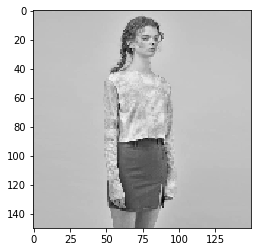

In [276]:
plt.imshow(items[0], cmap = 'gray')

In [277]:
items[0]

array([[0.7019608 , 0.7019608 , 0.7058824 , ..., 0.7176471 , 0.7176471 ,
        0.7176471 ],
       [0.7019608 , 0.7019608 , 0.7058824 , ..., 0.7176471 , 0.7176471 ,
        0.7176471 ],
       [0.7058824 , 0.7058824 , 0.7058824 , ..., 0.7176471 , 0.72156864,
        0.72156864],
       ...,
       [0.69411767, 0.69411767, 0.69411767, ..., 0.6901961 , 0.69411767,
        0.69411767],
       [0.6901961 , 0.6901961 , 0.69411767, ..., 0.6901961 , 0.6901961 ,
        0.6901961 ],
       [0.6901961 , 0.6901961 , 0.69411767, ..., 0.6901961 , 0.6901961 ,
        0.6901961 ]], dtype=float32)

In [ ]:
for item in items:
    